# Pytorch Tutorial Basics - Identifying Surface Sites with Desirable Adsorption Energies Using Binary Classification

### By Christoff Reimer
###15/7/2021

Hello and welcome to this tutorial.  I am something of an ML neophyte, so this will be good practice for me and for you, brave students.

In this tutorial, we will endeavour to create a rudimentary binary classification neural network to identify sites on a material surface that meet some characteristic chosen by us (a suitable adsorption energy for instance).  In this case, we will create and label a randomly generated set of surfaces from a short list of atoms using the Atomic Simulation Environment (ASE) module, one of several excellent Python tools for working with materials science topics.

Let us begin by importing our litany of functions and modules

# Importing Tools

In [ ]:
import numpy as np
import pickle
from random import random, randint
from math import factorial as fact
from math import cos, sin, pi, radians
!pip install ASE
from ase import Atoms, neighborlist
from ase.data import covalent_radii
#Pre-built lattices, and the add_adsorbate function
from ase.build import surface, bulk, fcc100, add_adsorbate
#R/W functions
from ase.io import read,write
#Visualizing
from ase.visualize.plot import plot_atoms
from ase.lattice.cubic import FaceCenteredCubic
# Calculating
from ase.calculators.emt import EMT
#Graphs and nodes module
import networkx as nx
#for basic plotting
import matplotlib.pyplot as plt
#for python math efficiency
from copy import deepcopy
# Assorted ML imports
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset
from torchvision import datasets, transforms
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss
from torch.optim import SGD
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Method for finding unique entries in a list
#Sourced from https://stackoverflow.com/questions/12897374/get-unique-values-from-a-list-in-python
def uniques(trends): 
    output = []
    for x in trends:
        if x not in output:
            output.append(x)
    return output

Using cpu device


# Now let us create our Atom and Surface Objects

There are many ways to set up an ASE representation of a surface.  My favourite is to use the default slab building method on a pure elemental surface such as Cu, and then replace the atoms with something else that I want instead.  This isn't perfect, but it is effective.

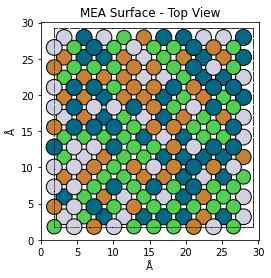

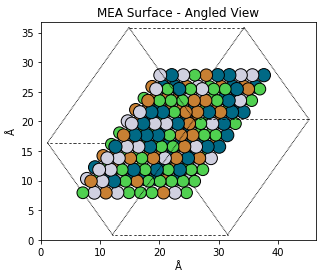

Finished


In [ ]:
# Defines the composition of the slab in a paired list output for chemical numbers and symbols
# This lets us know what the surface is made of
def Slab_composition_identifier(Atoms_object):
    entries = []

    entries = [Atoms_object.get_chemical_symbols(), Atoms_object.get_atomic_numbers()]
    
    elem_list = unique_finder(entries[0])
    num_list = unique_finder(entries[1])
    
    return [elem_list, num_list]

# This is a method for generating a random atom from the uniform distribution
# This works by dividing up the range from 0 to 1 into even chunks representing the probability of picking an element from atom_id_list
def Rand_Atom(atom_id_list):
    picker = ''
    num_atoms = len(atom_id_list)
    
    shift = 0
    interval_size = 1/num_atoms
    randval = random()
    
    for i in range(num_atoms):
        if shift <= randval <= (shift + interval_size):
            picker = atom_id_list[i]
        shift += interval_size
        
    return picker

#################################### Initialize Slab

# We need to pick our calculator here too.  EMT is a great starting place for beginners and for quick, cheap calculations of energies for some basic elements.  See the documentation for more information and more accurate calculators.
calc = EMT()

# Some lists we will need later
EMT_nrg_list = []
ASE_list = []
Atom_positions = []

# The Medium Entropy Alloy (MEA) composition that we want
atom_id_list = ['Ni', 'Cu', 'Pd', 'Pt']

# The dimensions of our slab in terms of atoms along each axis
X, Y, Z = 10,10,2

# Basic Slab setup using pre-defined fcc100 from ASE
# This serves as a template for our MEA slab
slab = fcc100('Pd', size=(X, Y, Z), vacuum= 10, orthogonal=True)

# Extracts distances from each atom to the others as a matrix
Atomic_distances = slab.get_all_distances(mic = True)
# Gets the x/y/z coordinates for each atom
Atomic_positions = slab.get_positions()
# Tells us what the slab is made of and where
Atomic_chemicals = slab.get_chemical_symbols()
Atomic_nums = slab.get_atomic_numbers()

# The two items below will be how we create a new surface
# This string will store all of our new randomly generated element assignments
Atom_string = ''
# A list to hold the atom positions of our new slab
Atom_Nu_positions = []

# Fill our surface items with the information we need to make the new MEA slab
for i in range(len(slab)):
    Atom_string += Rand_Atom(atom_id_list)
    Atom_Nu_positions.append(Atomic_positions[i])

Cell_Nu = slab.get_cell()
Atoms_MEA = Atoms(Atom_string, positions = Atom_Nu_positions, cell = Cell_Nu)

indices_set = (0,0,1)
slab_MEA = surface(Atoms_MEA, indices = indices_set, layers = 1, vacuum = 10)
#print(len(slab_MEA))

# Set EMT as the default calculator and get the potential energy of the surface
slab_MEA.calc = calc
E_slab = slab_MEA.get_potential_energy()

# View slab
fig, ax = plt.subplots()
plot_atoms(slab_MEA, ax, radii=0.8, rotation=('0x,0y,0z'))
plt.title('MEA Surface - Top View')
plt.xlabel('Å')
plt.ylabel('Å')
plt.show()

# View slab
fig, ax = plt.subplots()
plot_atoms(slab_MEA, ax, radii=0.8, rotation=('45x,45y,0z'))
plt.title('MEA Surface - Angled View')
plt.xlabel('Å')
plt.ylabel('Å')
plt.show()

print('Finished')

# Finding all the sites on the surface

To do this next step, we must first figure out what the neighbours of each site are.

Then we can work to figure out cell dimensions and from them find the possible adsorption sites in an expression that will work with the Add_adsorbate function in ASE.

We expect the surface to look like this figure [from the web](https://zacros.org/images/tutorial_pics/tut005_fig01.png)
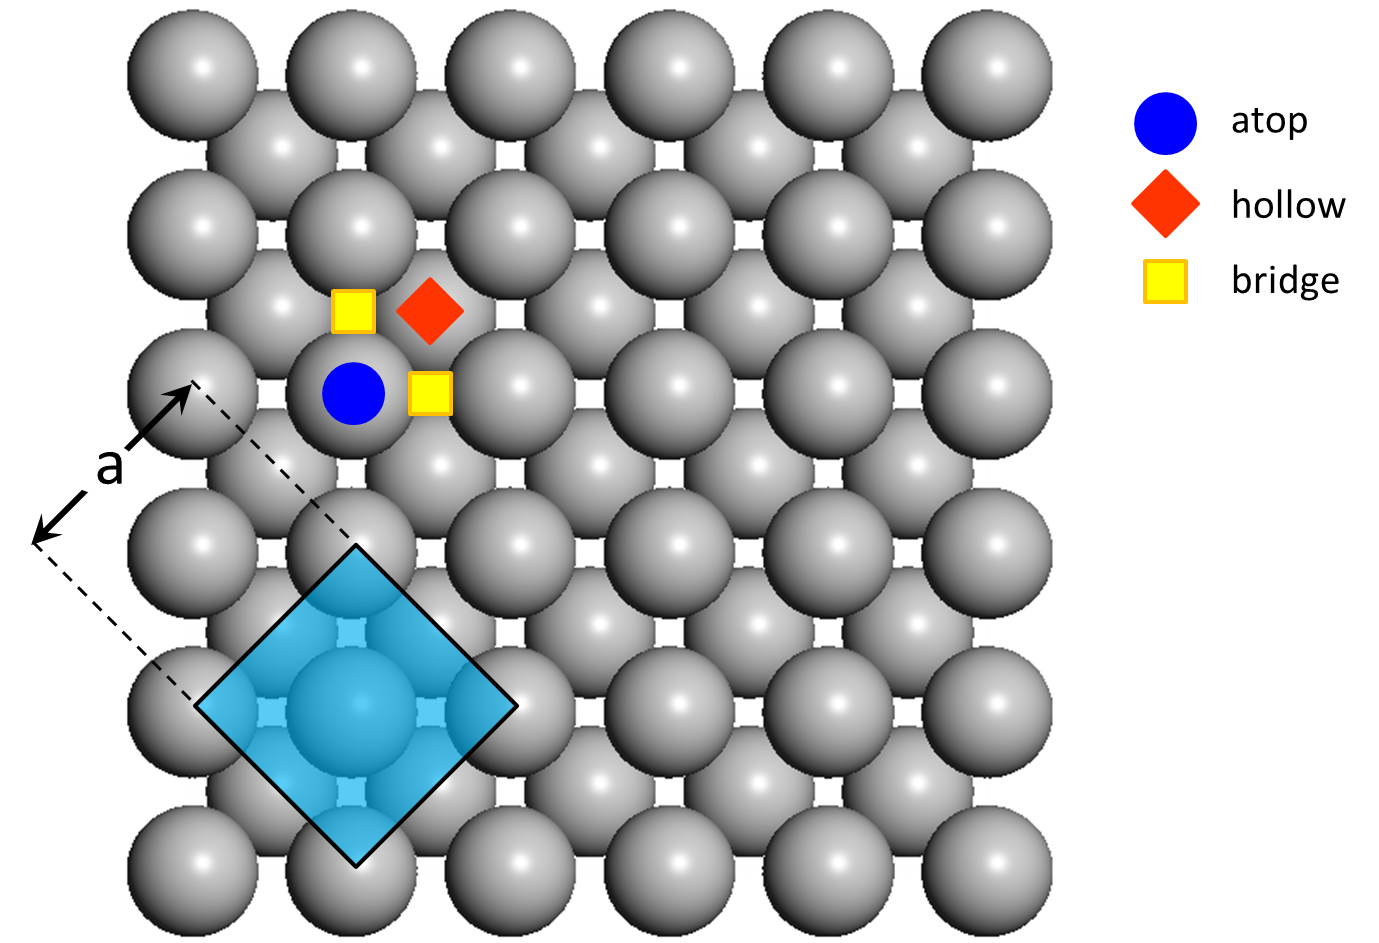


/usr/local/lib/python3.7/dist-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


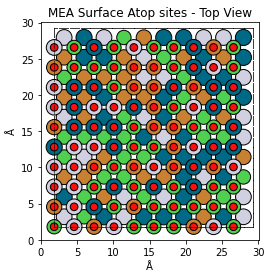

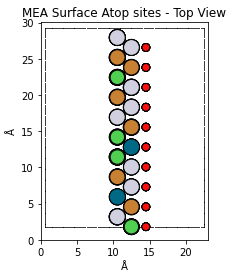

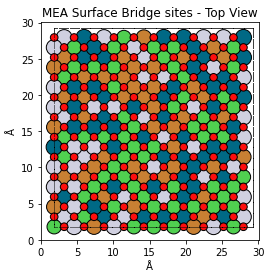

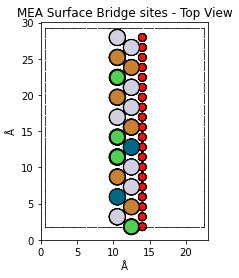

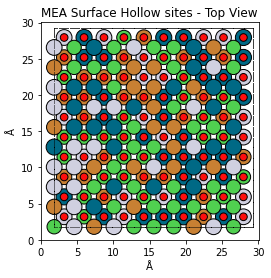

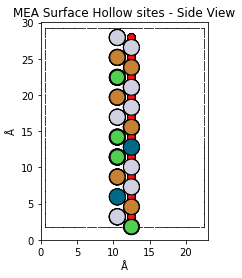

In [ ]:
# A set of dictionaries that will have keys of the coordinates for each site
Site_neighbours_Atop = {}
Site_neighbours_Bridge = {}
Site_neighbours_Hollow = {}

# Find the most likely bond distance by picking the smallest nonzero entry in the list (in this case it is done by slicing the first entry out of the list that we sweep through)
Min_Inter_Atomic_Distance = min(Atomic_distances[0][1:len(Atomic_distances)])

# Create a blank list to hold our values
Nearest_neighbours = [[] for i in range(slab_MEA)]

# Let us get the indices for the neighbours of each atom, where the index of the Nearest_neighbours list is the atom the neighbours belong to
for i in range(slab_MEA):
  Atomic_array = np.array(Atomic_distances[i])
  Undershoot = (Atomic_array < (Min_Inter_Atomic_Distance + 0.1)).astype(int)
  Overshoot = (Atomic_array > (Min_Inter_Atomic_Distance - 0.1)).astype(int)
  Nearest_neighbours[i] = np.nonzero(((Undershoot + Overshoot) == 2).astype(int))[0]
  Nearest_neighbours[i] = Nearest_neighbours[i].reshape(1, Nearest_neighbours[i].shape[0])

# Let us sample the slab and obtain ALL possible sites for each binding site and their locations
# This can be tricky, since the add_adsorbate coordinate system is in terms of basis units of the surface cell
MEA_Elements = slab_MEA.get_chemical_symbols()
cell_dimensions = slab_MEA.get_cell_lengths_and_angles()
cell_positions = slab_MEA.get_positions()
cellX = cell_dimensions[0]
cellY = cell_dimensions[1]

siteX = []
siteY = []
offsetX = []
offsetY = []
for i in range(len(cell_positions)):
    siteX.append(cell_positions[i][0])
    siteY.append(cell_positions[i][1])
    offsetX.append(siteX[i] / cellX)
    offsetY.append(siteY[i] / cellY)

#Make tuples to pass to offset
Atop_viable_sites = []
Bridge_viable_sites = []
Hollow_viable_sites = []

# find layer heights
heights = []
for i in range(len(cell_positions)):
  heights.append(cell_positions[i][2])

top_height = max(heights)
bottom_height = min(heights)

# The left-right and up-down spacing
LR_spacing = abs(cell_positions[0][0] - cell_positions[1][0])/cellX
UD_spacing = abs(cell_positions[0][1] - cell_positions[Y][1])/cellY

for i in range(len(cell_positions)):
  if cell_positions[i][2] >= (top_height - 0.1):
     Atop_viable_sites.append((offsetX[i], offsetY[i]))

Ads_heights = [2, 1.5, 0]

# Now we can test how things are going by making a copy and adding some adsorbed atoms to it.  Let us choose Oxygen, since it is usually a pleasing cherry red and will be very visible
Test_slab_MEA_Atop = deepcopy(slab_MEA)
for sites in Atop_viable_sites:
  add_adsorbate(Test_slab_MEA_Atop, "O", Ads_heights[0], offset = sites)

fig, ax = plt.subplots()
plot_atoms(Test_slab_MEA_Atop, ax, radii=0.8, rotation=('0x,0y,0z'))
plt.title('MEA Surface Atop sites - Top View')
plt.xlabel('Å')
plt.ylabel('Å')
plt.show()
fig, ax = plt.subplots()
plot_atoms(Test_slab_MEA_Atop, ax, radii=0.8, rotation=('0x,90y,0z'))
plt.title('MEA Surface Atop sites - Top View')
plt.xlabel('Å')
plt.ylabel('Å')
plt.show()

for i in range(len(cell_positions)):
  # Just the top layer of atoms
  if cell_positions[i][2] >= (top_height - 0.1):
    Atop_viable_sites.append((offsetX[i], offsetY[i]))
    Site_neighbours_Atop[(offsetX[i], offsetY[i])] = ((i), Nearest_neighbours[i])

for i in range(len(cell_positions)):
  # Just the top layer of atoms
  if cell_positions[i][2] >= (top_height - 0.1):
    Bridge_viable_sites.append((offsetX[i] + (LR_spacing/2), offsetY[i]))
    Bridge_viable_sites.append((offsetX[i], offsetY[i] + (UD_spacing/2)))
    # Handle case I (left-right bridge)
    if (i+1)%X == 0 and cell_positions[i][2] == cell_positions[((X*Y) + X - 1)][2]:
      Site_neighbours_Bridge[Bridge_viable_sites[-2]] = ((i, i - (X - 1)), np.concatenate((Nearest_neighbours[i].flatten(), Nearest_neighbours[i - (X - 1)].flatten())))
    else:
      Site_neighbours_Bridge[Bridge_viable_sites[-2]] = ((i, i + 1), np.concatenate((Nearest_neighbours[i].flatten(), Nearest_neighbours[i + 1].flatten())))
    # Handle case II (up-down bridge bridge)
    if i < ((X*Y) + X):
      Site_neighbours_Bridge[Bridge_viable_sites[-1]] = ((i, i + ((X*Y) - X)), np.concatenate((Nearest_neighbours[i].flatten(), Nearest_neighbours[i + ((X*Y) - X)].flatten())))
    elif i < len(cell_positions) - X:
      Site_neighbours_Bridge[Bridge_viable_sites[-1]] = ((i, i + X), np.concatenate((Nearest_neighbours[i].flatten(), Nearest_neighbours[i + X].flatten())))

Test_slab_MEA_Bridge = deepcopy(slab_MEA)
for sites in Bridge_viable_sites:
  add_adsorbate(Test_slab_MEA_Bridge, "O", Ads_heights[1], offset = sites)

fig, ax = plt.subplots()
plot_atoms(Test_slab_MEA_Bridge, ax, radii=0.8, rotation=('0x,0y,0z'))
plt.title('MEA Surface Bridge sites - Top View')
plt.xlabel('Å')
plt.ylabel('Å')
plt.show()
fig, ax = plt.subplots()
plot_atoms(Test_slab_MEA_Bridge, ax, radii=0.8, rotation=('0x,90y,0z'))
plt.title('MEA Surface Bridge sites - Top View')
plt.xlabel('Å')
plt.ylabel('Å')
plt.show()

for i in range(len(cell_positions)):
  # Just the top layer of atoms
  if cell_positions[i][2] <= (top_height - 0.1):
    Hollow_viable_sites.append((offsetX[i], offsetY[i]))
    Site_neighbours_Hollow[(offsetX[i], offsetY[i])] = ((i), Nearest_neighbours[i])

Test_slab_MEA_Hollow = deepcopy(slab_MEA)
for sites in Hollow_viable_sites:
  add_adsorbate(Test_slab_MEA_Hollow, "O", Ads_heights[2], offset = sites)

fig, ax = plt.subplots()
plot_atoms(Test_slab_MEA_Hollow, ax, radii=0.8, rotation=('0x,0y,0z'))
plt.title('MEA Surface Hollow sites - Top View')
plt.xlabel('Å')
plt.ylabel('Å')
plt.show()
fig, ax = plt.subplots()
plot_atoms(Test_slab_MEA_Hollow, ax, radii=0.8, rotation=('0x,90y,0z'))
plt.title('MEA Surface Hollow sites - Side View')
plt.xlabel('Å')
plt.ylabel('Å')
plt.show()

# Getting Adsorption energies and neighbours to go with our sites

Now that we know where the adsorption sites are, we need to grab the corresponding energies.  When we do this, we should also grab the coordinating atom(s) and the nearest neighbours, or we will regret it later.

Note the adsorption height is arbitrary here and is chosen to be 2.5 Angstroms for Atop sites and 2 Angstroms for bridges and Hollow sites.

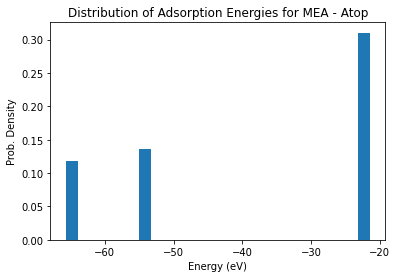

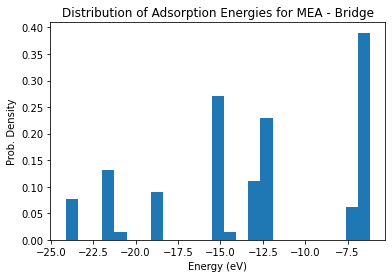

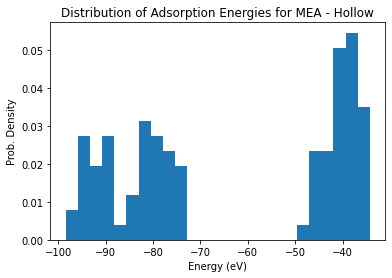

In [ ]:
# Get potential energy of slab
# This is static, we will only need to calculate it once
slab_MEA.calc = calc
E_slab = slab_MEA.get_potential_energy()

#OH (Adsorbate)
d = 1.022 #Set bond length
ads = Atoms('HO', positions=[(0, 0, 0), (0, 0, -d)], calculator = EMT()) #Creates an OH atom - The alignment is along z
# Get potential energy of OH
E_adsorbate = ads.get_potential_energy()

Site_nrgs_Atop = {}
Site_nrgs_Bridge = {}
Site_nrgs_Hollow = {}

for sites in Atop_viable_sites:
  slab_MEA_nrg = deepcopy(slab_MEA)
  add_adsorbate(slab_MEA_nrg, ads, Ads_heights[0], offset = sites)
  slab_MEA_nrg.calc = calc
  E_sys = slab_MEA_nrg.get_potential_energy()
  E_adsorption = -E_sys + E_slab + E_adsorbate
  Site_nrgs_Atop[sites] = E_adsorption
  # fig, ax = plt.subplots()
  # plot_atoms(slab_MEA_nrg, ax, radii=0.5, rotation=('0x,0y,0z'))
  # plt.show()

for sites in Bridge_viable_sites:
  slab_MEA_nrg = deepcopy(slab_MEA)
  add_adsorbate(slab_MEA_nrg, ads, Ads_heights[1], offset = sites)
  slab_MEA_nrg.calc = calc
  E_sys = slab_MEA_nrg.get_potential_energy()
  E_adsorption = -E_sys + E_slab + E_adsorbate
  Site_nrgs_Bridge[sites] = E_adsorption
  # fig, ax = plt.subplots()
  # plot_atoms(slab_MEA_nrg, ax, radii=0.5, rotation=('0x,0y,0z'))
  # plt.show()

for sites in Hollow_viable_sites:
  slab_MEA_nrg = deepcopy(slab_MEA)
  add_adsorbate(slab_MEA_nrg, ads, Ads_heights[2], offset = sites)
  slab_MEA_nrg.calc = calc
  E_sys = slab_MEA_nrg.get_potential_energy()
  E_adsorption = -E_sys + E_slab + E_adsorbate
  Site_nrgs_Hollow[sites] = E_adsorption
  # fig, ax = plt.subplots()
  # plot_atoms(slab_MEA_nrg, ax, radii=0.5, rotation=('0x,0y,0z'))
  # plt.show()

plt.hist(Site_nrgs_Atop.values(), bins = 25, density = True)
plt.title('Distribution of Adsorption Energies for MEA - Atop')
plt.xlabel("Energy (eV)")
plt.ylabel("Prob. Density")
plt.show()
plt.hist(Site_nrgs_Bridge.values(), bins = 25, density = True)
plt.title('Distribution of Adsorption Energies for MEA - Bridge')
plt.xlabel("Energy (eV)")
plt.ylabel("Prob. Density")
plt.show()
plt.hist(Site_nrgs_Hollow.values(), bins = 25, density = True)
plt.title('Distribution of Adsorption Energies for MEA - Hollow')
plt.xlabel("Energy (eV)")
plt.ylabel("Prob. Density")
plt.show()

# Converting our site data into element data

Now that we have all this data to work with, let us narrow our focus back down and begin to pull together what we need to make a fingerprint for each site that tells us its composition and energy.

For each site dictionary, we will be looking through the neighbours lists that we have made and checking to figure out which layer they sit on.

The fingerprint that is shown in this tutorial has three segments.  One represents the atom(s) directly in contact with the adsorbate.  The next represents the nearest neighbours of the atom(s) in the first set that share a layer with them.  The third set represents the nearest neighbours of the atom(s) in the first set that do not share a layer with the atoms in the first set.


In [ ]:
Comprehensive_dict_Atop = {}
Comprehensive_dict_Bridge = {}
Comprehensive_dict_Hollow = {}

for values in Site_neighbours_Atop:
  temp1 = Site_neighbours_Atop[values][0]
  Elem1 = MEA_Elements[temp1]
  temp2 = [num for num in Site_neighbours_Atop[values][1].flatten() if cell_positions[num][2] >= (top_height - 0.1)]
  Elem2 = [MEA_Elements[num] for num in uniques(temp2)]
  temp3 = [num for num in Site_neighbours_Atop[values][1].flatten() if cell_positions[num][2] < (top_height - 0.1)]
  Elem3 = [MEA_Elements[num] for num in uniques(temp3)]
  Assortment = ((Elem1), tuple(Elem2), tuple(Elem3))
  Comprehensive_dict_Atop[Assortment] = Site_nrgs_Atop[values]

for values in Site_neighbours_Bridge:
  temp1 = Site_neighbours_Bridge[values][0]
  Elem1 = [MEA_Elements[num] for num in uniques(temp1)]
  temp2 = [num for num in Site_neighbours_Bridge[values][1].flatten() if cell_positions[num][2] >= (top_height - 0.1)]
  Elem2 = [MEA_Elements[num] for num in uniques(temp2) if num not in temp1]
  temp3 = [num for num in Site_neighbours_Bridge[values][1].flatten() if cell_positions[num][2] < (top_height - 0.1)]
  Elem3 = [MEA_Elements[num] for num in uniques(temp3)]
  Assortment = (tuple(Elem1), tuple(Elem2), tuple(Elem3))
  Comprehensive_dict_Bridge[Assortment] = Site_nrgs_Bridge[values]

for values in Site_neighbours_Hollow:
  temp1 = Site_neighbours_Hollow[values][0]
  Elem1 = MEA_Elements[temp1]
  temp2 = [num for num in Site_neighbours_Hollow[values][1].flatten() if cell_positions[num][2] >= (top_height - 0.1)]
  Elem2 = [MEA_Elements[num] for num in uniques(temp2)]
  temp3 = [num for num in Site_neighbours_Hollow[values][1].flatten() if cell_positions[num][2] < (top_height - 0.1)]
  Elem3 = [MEA_Elements[num] for num in uniques(temp3)]
  Assortment = ((Elem1), tuple(Elem2), tuple(Elem3))
  Comprehensive_dict_Hollow[Assortment] = Site_nrgs_Hollow[values]

print(Comprehensive_dict_Atop)
print(Comprehensive_dict_Bridge)
print(Comprehensive_dict_Hollow)

{('Ni', ('Pt', 'Ni', 'Cu', 'Pt'), ('Pt', 'Pt', 'Pt', 'Pd')): -21.564122115884683, ('Pt', ('Ni', 'Cu', 'Pt', 'Ni'), ('Pt', 'Ni', 'Pt', 'Pd')): -65.58627446843644, ('Cu', ('Pt', 'Pt', 'Pd', 'Pd'), ('Ni', 'Pd', 'Pd', 'Pt')): -22.08285465090975, ('Pt', ('Cu', 'Ni', 'Ni', 'Ni'), ('Pd', 'Pt', 'Pt', 'Ni')): -65.4539310609517, ('Ni', ('Pt', 'Ni', 'Cu', 'Pt'), ('Pt', 'Pd', 'Ni', 'Cu')): -21.5262186259458, ('Ni', ('Ni', 'Ni', 'Ni', 'Ni'), ('Pd', 'Pd', 'Cu', 'Pd')): -21.40613958901559, ('Ni', ('Ni', 'Cu', 'Ni', 'Ni'), ('Pd', 'Pd', 'Pd', 'Pd')): -21.429962920889377, ('Cu', ('Ni', 'Pt', 'Ni', 'Pd'), ('Pd', 'Cu', 'Pd', 'Pt')): -22.002838282068918, ('Pt', ('Cu', 'Ni', 'Ni', 'Cu'), ('Cu', 'Pd', 'Pt', 'Pt')): -65.4836339909993, ('Ni', ('Ni', 'Pt', 'Ni', 'Ni'), ('Pd', 'Pt', 'Pt', 'Pd')): -21.496917131761048, ('Cu', ('Ni', 'Pt', 'Ni', 'Pt'), ('Pt', 'Pt', 'Pd', 'Pt')): -22.054312762523406, ('Pt', ('Pt', 'Cu', 'Pd', 'Pt'), ('Pt', 'Ni', 'Pd', 'Ni')): -65.68241336717296, ('Pd', ('Cu', 'Pt', 'Ni', 'Ni'), ('Ni

# Representing our sites in a vector fingerprint

With our sites identified correctly, we can now decide on how to represent a site on the surface for the purposes of this tutorial.  First let us try to merge all the types of site together into one unified format as described previously.  If one site type does not have any atoms for a given spot, we will append a list of zero values to that position.

Each atom is identified by a list of 4 values, 3 of which should always be zeros.  Each one of the spots in this list represents a specific element.

In [ ]:
dataset_Atop = []

print('Atop')

for keys in Comprehensive_dict_Atop:
  fingerprint = []
  Protoform1 = [0,0,0,0]
  if keys[0] == atom_id_list[0]:
    Protoform1[0] = 1
  elif keys[0] == atom_id_list[1]:
    Protoform1[1] = 1
  elif keys[0] == atom_id_list[2]:
    Protoform1[2] = 1
  elif keys[0] == atom_id_list[3]:
    Protoform1[3] = 1

  fingerprint.append(Protoform1)
  fingerprint.append([0,0,0,0])
  
  for entries in keys[1]:
    Protoform2 = [0,0,0,0]
    if entries == atom_id_list[0]:
      Protoform2[0] = 1
    elif entries == atom_id_list[1]:
      Protoform2[1] = 1
    elif entries == atom_id_list[2]:
      Protoform2[2] = 1
    elif entries == atom_id_list[3]:
      Protoform2[3] = 1

    fingerprint.append(Protoform2)

  for i in range(2):
    fingerprint.append([0,0,0,0])

  for entries in keys[2]:
    Protoform3 = [0,0,0,0]
    if entries == atom_id_list[0]:
      Protoform3[0] = 1
    elif entries == atom_id_list[1]:
      Protoform3[1] = 1
    elif entries == atom_id_list[2]:
      Protoform3[2] = 1
    elif entries == atom_id_list[3]:
      Protoform3[3] = 1
    
    fingerprint.append(Protoform3)

  for i in range(2):
    fingerprint.append([0,0,0,0])

  print(fingerprint)

  dataset_Atop.append(np.array(fingerprint).flatten())

dataset_Bridge = []

print('Bridge')

for keys in Comprehensive_dict_Bridge:

  fingerprint = []
  
  for entries in keys[0]:
    Protoform1 = [0,0,0,0]
    if entries == atom_id_list[0]:
      Protoform1[0] = 1
    elif entries == atom_id_list[1]:
      Protoform1[1] = 1
    elif entries == atom_id_list[2]:
      Protoform1[2] = 1
    elif entries == atom_id_list[3]:
      Protoform1[3] = 1

    fingerprint.append(Protoform1)
  
  for entries in keys[1]:
    Protoform2 = [0,0,0,0]
    if entries == atom_id_list[0]:
      Protoform2[0] = 1
    elif entries == atom_id_list[1]:
      Protoform2[1] = 1
    elif entries == atom_id_list[2]:
      Protoform2[2] = 1
    elif entries == atom_id_list[3]:
      Protoform2[3] = 1

    fingerprint.append(Protoform2)

  for entries in keys[2]:
    Protoform3 = [0,0,0,0]
    if entries == atom_id_list[0]:
      Protoform3[0] = 1
    elif entries == atom_id_list[1]:
      Protoform3[1] = 1
    elif entries == atom_id_list[2]:
      Protoform3[2] = 1
    elif entries == atom_id_list[3]:
      Protoform3[3] = 1
    
    fingerprint.append(Protoform3)

  print(fingerprint)

  dataset_Bridge.append(np.array(fingerprint).flatten())


dataset_Hollow = []

print('Hollow')

for keys in Comprehensive_dict_Hollow:

  fingerprint = []
  
  Protoform1 = [0,0,0,0]
  if keys[0] == atom_id_list[0]:
    Protoform1[0] = 1
  elif keys[0] == atom_id_list[1]:
    Protoform1[1] = 1
  elif keys[0] == atom_id_list[2]:
    Protoform1[2] = 1
  elif keys[0] == atom_id_list[3]:
    Protoform1[3] = 1

  fingerprint.append(Protoform1)
  fingerprint.append([0,0,0,0])
  
  for entries in keys[1]:
    Protoform2 = [0,0,0,0]
    if entries == atom_id_list[0]:
      Protoform2[0] = 1
    elif entries == atom_id_list[1]:
      Protoform2[1] = 1
    elif entries == atom_id_list[2]:
      Protoform2[2] = 1
    elif entries == atom_id_list[3]:
      Protoform2[3] = 1

    fingerprint.append(Protoform2)
  
  for i in range(2):
    fingerprint.append([0,0,0,0])

  for entries in keys[2]:
    Protoform3 = [0,0,0,0]
    if entries == atom_id_list[0]:
      Protoform3[0] = 1
    elif entries == atom_id_list[1]:
      Protoform3[1] = 1
    elif entries == atom_id_list[2]:
      Protoform3[2] = 1
    elif entries == atom_id_list[3]:
      Protoform3[3] = 1

    fingerprint.append(Protoform3)

  for i in range(2):
    fingerprint.append([0,0,0,0])

  print(fingerprint)
  dataset_Hollow.append(np.array(fingerprint).flatten())

Atop
[[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
[[0, 0, 0, 1], [0, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
[[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]]
[[0, 0, 0, 1], [0, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
[[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
[[1, 0, 0,

# Creating our dataset

To create our dataset, let us select an arbitrary threshold to help the classifier later, and then give each site a label based on whether it meets the energy threshold we set for it.

We will also randomly split our dataset.

(from https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/)

(Also from https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader)

In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.001

In [ ]:
threshold = -40
Energy_labels_Hollow = np.array(list(Site_nrgs_Hollow.values())).reshape(len(Site_nrgs_Hollow.values()), 1)
Energy_labels_Hollow = 1.0*(Energy_labels_Hollow < threshold)

print(len(Energy_labels_Hollow))

X_data = dataset_Hollow
Y_data = Energy_labels_Hollow

tensor_x = torch.Tensor(X_data) # transform to torch tensor
tensor_y = torch.Tensor(Y_data)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader

len_train = 90
len_test = 10
train_data, test_data = random_split(my_dataset, [len_train, len_test], generator=torch.Generator().manual_seed(42))

# Create data loaders
train_dataloader = DataLoader(train_data, batch_size = 15, drop_last = True, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = len_test, drop_last = True, shuffle = True)

print("total dset len: ", len(my_dataloader.dataset))

for X, y in test_dataloader:
    print("Shape of X [N, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

print('Finished')

100
total dset len:  100
Shape of X [N, W]:  torch.Size([10, 56])
Shape of y:  torch.Size([10, 1]) torch.float32
Finished


# Creating A Pytorch Model

Using Pytorch we can create a binary classification NN with some dropout regulatization.

(from https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Number of input features is 56.
        self.layer_1 = nn.Linear(56, 30) 
        self.layer_2 = nn.Linear(30, 15)
        self.layer_out = nn.Linear(15, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(30)
        self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=56, out_features=30, bias=True)
  (layer_2): Linear(in_features=30, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


# Choosing a Loss function and Optimizer

Using the BCEWithLogitsLoss loss function setup for our NN is handy since it automatically applies the sigmoid activation function to the output of our NN, which is what we want for binary classification.

(from https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# This Binary Cross Entropy loss function automatically applies the sigmoid function to the output
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

cpu


# Training the Model

We are finally ready to train our model.  In addition to the loss and accuracy for each epoch, we present the confusion matrix, which shows on the diagonal how many entries have been correctly categorized.

(from https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_dataloader):.5f} | Acc: {epoch_acc/len(train_dataloader):.3f}')

print("Now Testing")

y_test = []
y_pred_list = []
model.eval()
with torch.no_grad():
  for X_batch, y_batch in test_dataloader:
    X_batch = X_batch.to(device)
    y_test.append(y_batch)
    y_test_pred = model(X_batch)
    y_test_pred = torch.sigmoid(y_test_pred)
    y_pred_tag = torch.round(y_test_pred)
    y_pred_list.append(y_pred_tag.cpu().numpy())

y_test = torch.stack(y_test)
y_test_list = [a.squeeze().tolist() for a in y_test][0]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list][0]

print(y_pred_list)
print(y_test_list)

results = confusion_matrix(y_test_list, y_pred_list)
print('Confusion Matrix')
print(results)
print("And now we can say that we have made correct predictions for", ((results[0][0] + results[1][1])/len(y_test_list) * 100), "% of our data")

Epoch 001: | Loss: 0.68672 | Acc: 55.667
Epoch 002: | Loss: 0.53554 | Acc: 76.667
Epoch 003: | Loss: 0.42712 | Acc: 88.833
Epoch 004: | Loss: 0.33611 | Acc: 92.000
Epoch 005: | Loss: 0.23127 | Acc: 92.167
Epoch 006: | Loss: 0.16720 | Acc: 94.333
Epoch 007: | Loss: 0.12688 | Acc: 95.500
Epoch 008: | Loss: 0.12181 | Acc: 96.500
Epoch 009: | Loss: 0.07992 | Acc: 97.667
Epoch 010: | Loss: 0.04916 | Acc: 100.000
Epoch 011: | Loss: 0.02650 | Acc: 100.000
Epoch 012: | Loss: 0.01568 | Acc: 100.000
Epoch 013: | Loss: 0.01842 | Acc: 100.000
Epoch 014: | Loss: 0.02738 | Acc: 98.833
Epoch 015: | Loss: 0.01944 | Acc: 100.000
Epoch 016: | Loss: 0.00624 | Acc: 100.000
Epoch 017: | Loss: 0.01356 | Acc: 100.000
Epoch 018: | Loss: 0.00791 | Acc: 100.000
Epoch 019: | Loss: 0.01195 | Acc: 100.000
Epoch 020: | Loss: 0.00600 | Acc: 100.000
Epoch 021: | Loss: 0.01730 | Acc: 98.833
Epoch 022: | Loss: 0.06559 | Acc: 97.833
Epoch 023: | Loss: 0.02253 | Acc: 100.000
Epoch 024: | Loss: 0.02957 | Acc: 98.833
Epoch

# Conclusion

Now we hope that you have learned something today about Pytorch and materials science.  

Feel free to experiment and try different thresholds for the fingerprints and the other site types.

Have a great day!


# Sources

The following tutorials and documentation helped make this tutorial possible:
1.   https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
2.   https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
3.   https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
4.   https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89






